In [3]:
import pandas as pd
import numpy as np
#import matplotlib
#matplotlib.use('Agg')
import matplotlib.pyplot as plt
import seaborn as sns
import sys
sys.path.insert(0,'../')
from utils.utils import *

import yaml
import argparse

In [13]:


def get_list_common_date(start, end, obs, list_df_pred):
    df = pd.concat([obs[['Datetime']].set_index('Datetime')[start:end]]+
                   [df_[['Datetime']].set_index('Datetime') for df_ in list_df_pred], axis=1, join='inner')
    return df.index.values.astype(str)

def mse(obs, pred):
    return ((pred - obs) ** 2).mean()


def rmse(obs, pred):
    return np.sqrt(mse(obs, pred))


def mae(obs, pred):
    return np.absolute(pred - obs).mean()


def mape_at(obs, pred):
    mask = obs >= AT
    return (np.absolute(pred[mask] - obs[mask]) / obs[mask]).mean()


def get_errors(obs, list_df_pred, list_name_pred, list_date, errors=[rmse, mae, mse, mape_at],
               errors_name=['rmse', 'mae', 'mse', 'mape_at' + str(AT)], ):
    data = []
    columns = ['model'] + errors_name
    obs = obs.set_index('Datetime').loc[list_date].values
    for df, name in zip(list_df_pred, list_name_pred):
        pred = df.set_index('Datetime').loc[list_date].values
        data.append([name] + [e(obs, pred).mean() for e in errors])
    return pd.DataFrame(data, columns=columns)


def error_per_station(obs, list_df_pred, list_name_pred, list_date, error=mape_at):
    data = []
    columns = ['__time_series__'] + list(obs.columns.values[1:])
    obs = obs.set_index('Datetime').loc[list_date].values
    for df, name in zip(list_df_pred, list_name_pred):
        pred = df.set_index('Datetime').loc[list_date].values
        data.append([name] + [error(obs[:, i], pred[:, i]) for i in range(pred.shape[1])])
    df = pd.DataFrame(data, columns=columns).set_index('__time_series__').T.reset_index()
    df.columns = np.array(['__time_series__'] + df.columns[1:].values.tolist()).astype(str)
    df['__index__'] = np.arange(len(df))
    return df

def plot(df_list, start_date, end_date, time_series, df_names, title, save=False):
    common_date_list = get_list_common_date(start_date, end_date, df_list[0],df_list[1:])
    df_toplot = [copy.deepcopy(df).set_index('Datetime').loc[common_date_list][time_series] for df in df_list]
    
    ax = df_toplot[0].plot(label=df_names[0], figsize = (15,3))
    final_names=[df_names[0]]
    for df,n in zip(df_toplot[1:],df_names[1:]):
        try:
            df.plot(ax=ax, label=n)
            final_names.append(n)
        except:
            pass

    plt.legend(labels = final_names)
    plt.xticks(rotation = 30)
    plt.title(title)
    if save!=False:
        plt.savefig(save, bbox_inches='tight', format='eps')
    plt.show()
    plt.close()

In [24]:
df_event = pd.read_csv('/home/toque/data2/montreal/events/data/clean/events_2015_2018.csv')
df_event[df_event['stop_id']==16].set_index('start_datetime')['2017-01-01':'2018-01-01'].head()

,end_datetime,stop_id,stop_name,event,crowds,category
start_datetime,,,,,,
2017-01-02 11:00:00,2017-01-02 13:00:00,16,Station Lucien-L'Allier,Championnat du monde hockey junior 2017,NaN,hockey
2017-01-02 15:30:00,2017-01-02 17:30:00,16,Station Lucien-L'Allier,Championnat du monde hockey junior 2017,NaN,hockey
2017-01-02 20:00:00,2017-01-02 22:00:00,16,Station Lucien-L'Allier,Championnat du monde hockey junior 2017,NaN,hockey
2017-01-03 17:30:00,2017-01-03 19:30:00,16,Station Lucien-L'Allier,Championnat du monde hockey junior 2017,NaN,hockey
2017-01-04 15:00:00,2017-01-04 17:00:00,16,Station Lucien-L'Allier,Championnat du monde hockey junior 2017,NaN,hockey


In [14]:
passA = pd.read_csv('/home/toque/data2/montreal/stm/data/valid_metro_2015_2016_2017_perpass_agregated/valid_metro_15min_2015_2016_2017_A-Mensuel_STM.csv')
passB = pd.read_csv('/home/toque/data2/montreal/stm/data/valid_metro_2015_2016_2017_perpass_agregated/valid_metro_15min_2015_2016_2017_B-Mensuel_regional.csv')
passC = pd.read_csv('/home/toque/data2/montreal/stm/data/valid_metro_2015_2016_2017_perpass_agregated/valid_metro_15min_2015_2016_2017_C-Carnets_de_billets.csv')
passD = pd.read_csv('/home/toque/data2/montreal/stm/data/valid_metro_2015_2016_2017_perpass_agregated/valid_metro_15min_2015_2016_2017_D-Titres_occasionnels.csv')

lt_rf_passA = pd.read_csv('/home/toque/data2/forecast/model/rf_uni_inverted/prediction/lt_rf_uni_inverted_passA/2015-01-01_2017-12-31.csv')
lt_rf_passB = pd.read_csv('/home/toque/data2/forecast/model/rf_uni_inverted/prediction/lt_rf_uni_inverted_passB/2015-01-01_2017-12-31.csv')
lt_rf_passC = pd.read_csv('/home/toque/data2/forecast/model/rf_uni_inverted/prediction/lt_rf_uni_inverted_passC/2015-01-01_2017-12-31.csv')
lt_rf_passD = pd.read_csv('/home/toque/data2/forecast/model/rf_uni_inverted/prediction/lt_rf_uni_inverted_passD/2015-01-01_2017-12-31.csv')

df_list_A = [passA, lt_rf_passA]
df_list_B = [passB, lt_rf_passB]
df_list_C = [passC, lt_rf_passC]
df_list_D = [passD, lt_rf_passD]

df_list_A_name = ['passA', 'lt_rf_passA']
df_list_B_name = ['passB', 'lt_rf_passB']
df_list_C_name = ['passC', 'lt_rf_passC']
df_list_D_name = ['passD', 'lt_rf_passD']

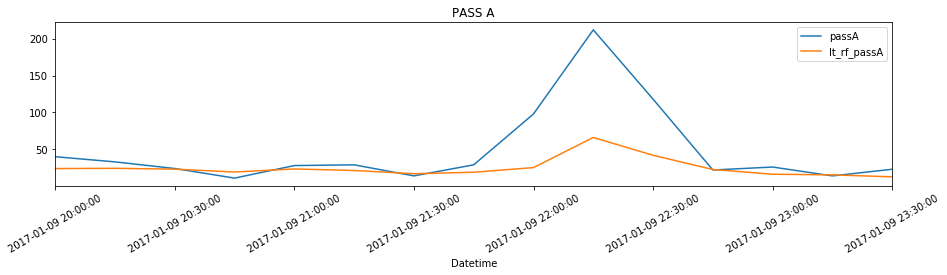

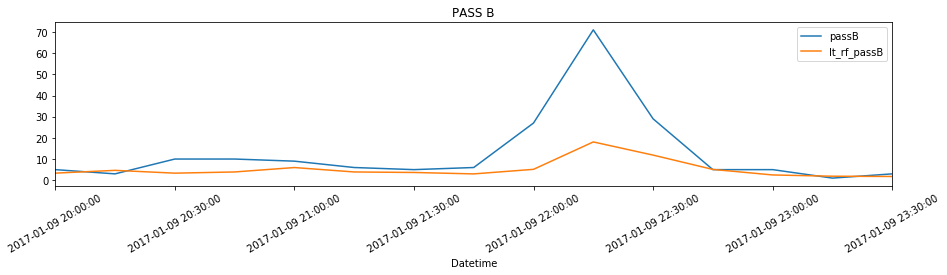

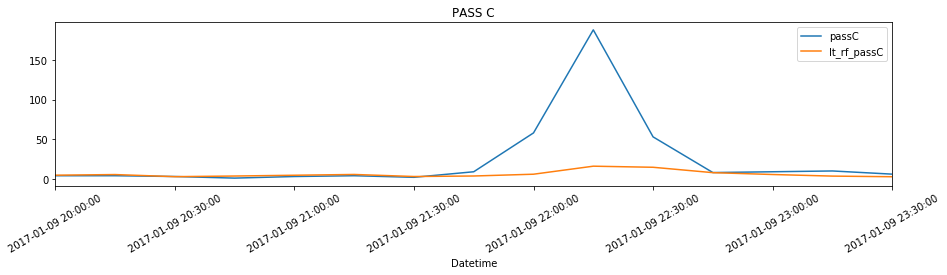

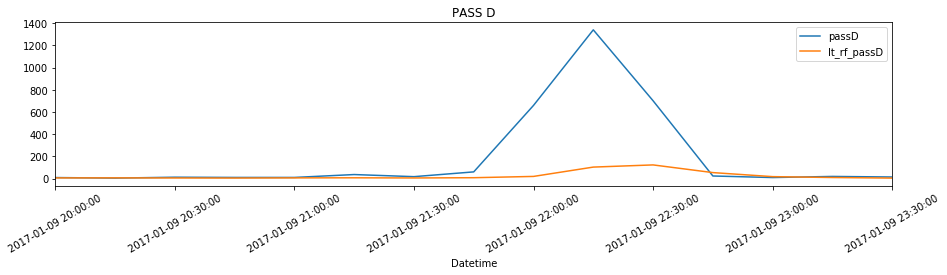

In [23]:
start_date = '2017-01-09 20:00:00'
end_date = '2017-01-09 23:30:00'
time_series = ['16']

plot(df_list_A, start_date, end_date, time_series, df_list_A_name, title='PASS A' )
plot(df_list_B, start_date, end_date, time_series, df_list_B_name, title='PASS B' )
plot(df_list_C, start_date, end_date, time_series, df_list_C_name, title='PASS C' )
plot(df_list_D, start_date, end_date, time_series, df_list_D_name, title='PASS D' )

In [ ]:
pd.read_csv('/home/toque/data2/montreal/events/data/clean/events_2015_2018_start_event_stopid_category.csv')

In [25]:
model_infos = load_pickle('/home/toque/data2/forecast/model/rf_uni_inverted/optimize/mt_rf_uni_inverted_events_categoryALLreduce_OPTIMALL/model_infos.pkl')

In [28]:
model_infos['features_exogenous']

['2-end_event',
 '3-end_event',
 '4-end_event',
 '5-end_event',
 '6-end_event',
 '8-end_event',
 '9-end_event',
 '10-end_event',
 '11-end_event',
 '12-end_event',
 '13-end_event',
 '14-end_event',
 '15-end_event',
 '16-end_event',
 '23-end_event',
 '24-end_event',
 '30-end_event',
 '31-end_event',
 '32-end_event',
 '34-end_event',
 '35-end_event',
 '40-end_event',
 '43-end_event',
 '45-end_event',
 '47-end_event',
 '61-end_event',
 '68-end_event',
 '1-start_event',
 '2-start_event',
 '3-start_event',
 '4-start_event',
 '5-start_event',
 '6-start_event',
 '8-start_event',
 '9-start_event',
 '10-start_event',
 '11-start_event',
 '12-start_event',
 '13-start_event',
 '14-start_event',
 '15-start_event',
 '16-start_event',
 '23-start_event',
 '24-start_event',
 '29-start_event',
 '30-start_event',
 '31-start_event',
 '32-start_event',
 '34-start_event',
 '35-start_event',
 '40-start_event',
 '43-start_event',
 '45-start_event',
 '47-start_event',
 '61-start_event',
 '68-start_event',
 '16-